In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.dates as dates
import seaborn as sns
sns.set()

table = '''
Date	Day rate reading	Night rate reading	Day rate estimate	Night rate estimate	Bill	Day Kwh	Night Kwh
2018-06-13	62523	44760					
2018-07-10	62578	44945					
2018-09-03			62953	45048	£87.13	375	103
2018-12-03			63673	45306	£169.05	720	258
2019-03-18	65592	47628					
2019-04-03			64500	45665	£197.00	827	359
2019-04-29	65936	48235			£516.48	1436	2570
2019-05-10	66162	48602			£77.98	226	367
2019-05-19	66218	48783					
2019-06-02	66255	49041			£67.05	93	439'''

# data
table_lines = [line.split('\t') for line in table.splitlines()[1:]]
df = pd.DataFrame({
    'date': [line[0] for line in table_lines[1:]],
    'day_actual': [line[1] for line in table_lines[1:]],
    'night_actual': [line[2] for line in table_lines[1:]],
    'day_estimate': [line[3] for line in table_lines[1:]],
    'night_estimate': [line[4] for line in table_lines[1:]],
    'bill': [line[5] for line in table_lines[1:]]
})
df = df[['date', 'day_actual', 'night_actual', 'day_estimate', 'night_estimate', 'bill']]
df

,date,day_actual,night_actual,day_estimate,night_estimate,bill
0,2018-06-13,62523,44760,,,
1,2018-07-10,62578,44945,,,
2,2018-09-03,,,62953,45048,£87.13
3,2018-12-03,,,63673,45306,£169.05
4,2019-03-18,65592,47628,,,
5,2019-04-03,,,64500,45665,£197.00
6,2019-04-29,65936,48235,,,£516.48
7,2019-05-10,66162,48602,,,£77.98
8,2019-05-19,66218,48783,,,
9,2019-06-02,66255,49041,,,£67.05


In [2]:
# processed data
df = df.assign(
    date=lambda x: pd.to_datetime(x.date, format='%Y-%m-%d'),
    day_actual=lambda x: pd.to_numeric(x.day_actual),
    night_actual=lambda x: pd.to_numeric(x.night_actual),
    day_estimate=lambda x: pd.to_numeric(x.day_estimate),
    night_estimate=lambda x: pd.to_numeric(x.night_estimate),
    bill=lambda x: x.bill.replace('', np.nan)
)
df.insert(1, 'days', (df['date'] - df['date'][0]).dt.days)
df

,date,days,day_actual,night_actual,day_estimate,night_estimate,bill
0,2018-06-13,0,62523.0,44760.0,NaN,NaN,NaN
1,2018-07-10,27,62578.0,44945.0,NaN,NaN,NaN
2,2018-09-03,82,NaN,NaN,62953.0,45048.0,£87.13
3,2018-12-03,173,NaN,NaN,63673.0,45306.0,£169.05
4,2019-03-18,278,65592.0,47628.0,NaN,NaN,NaN
5,2019-04-03,294,NaN,NaN,64500.0,45665.0,£197.00
6,2019-04-29,320,65936.0,48235.0,NaN,NaN,£516.48
7,2019-05-10,331,66162.0,48602.0,NaN,NaN,£77.98
8,2019-05-19,340,66218.0,48783.0,NaN,NaN,NaN
9,2019-06-02,354,66255.0,49041.0,NaN,NaN,£67.05


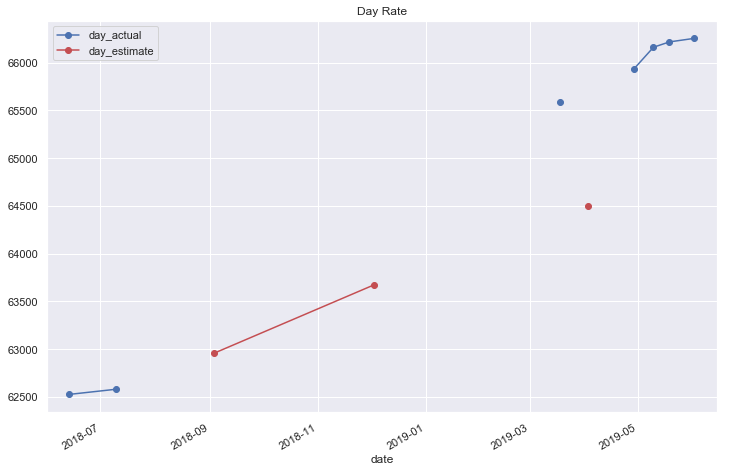

In [3]:
# plot
ax = df.plot(x='date', y=['day_actual', 'day_estimate'], style=['bo-', 'ro-'], figsize=(12,8))
_ = ax.set_xlim([pd.Timestamp('2018-06-01'), pd.Timestamp('2019-06-15')])
_ = ax.set_title('Day Rate')

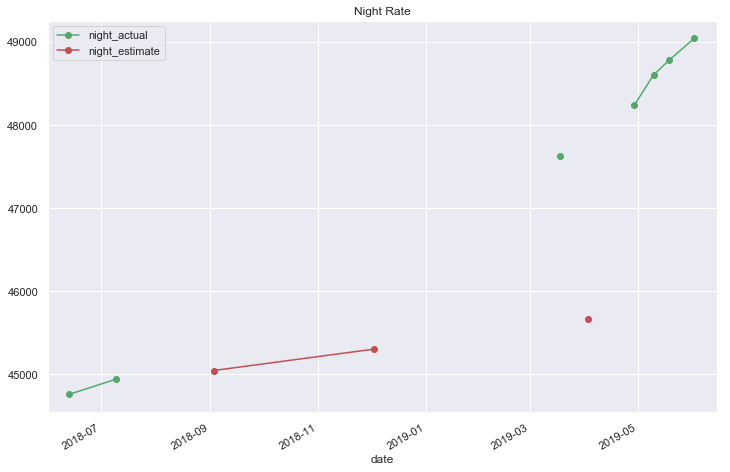

In [4]:
# plot
ax = df.plot(x='date', y=['night_actual', 'night_estimate'], style=['go-', 'ro-'], figsize=(12,8))
_ = ax.set_xlim([pd.Timestamp('2018-06-01'), pd.Timestamp('2019-06-15')])
_ = ax.set_title('Night Rate')

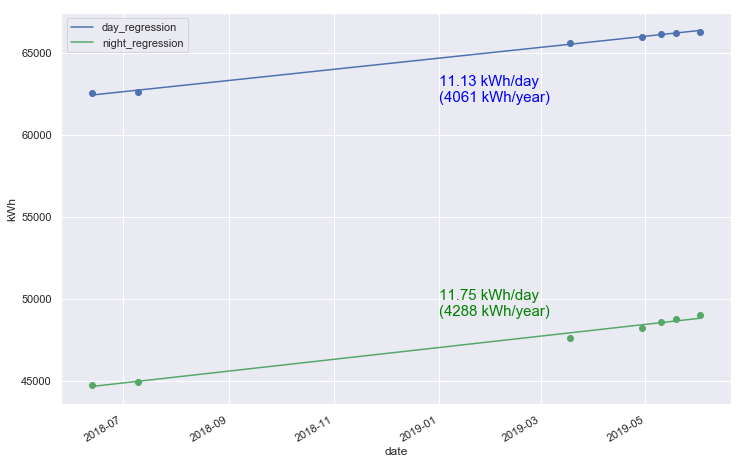

In [5]:
# simple linear regression
## actual day rate readings - remove dates where there's no actual readings
day_x = df[~df.day_actual.isin([np.nan])].days.values
day_y = df.day_actual.dropna().values
actual_day_rate, actual_day_start = np.polyfit(day_x, day_y, 1)
## actual day rate readings - remove dates where there's no actual readings
night_x = df[~df.night_actual.isin([np.nan])].days.values
night_y = df.night_actual.dropna().values
actual_night_rate, actual_night_start = np.polyfit(night_x, night_y, 1)
## Regression data
regression_df = pd.DataFrame({
    'date': [df['date'].iloc[0], df['date'].iloc[-1]],
    'day_regression': [actual_day_start, actual_day_rate * df['days'].iloc[-1] + actual_day_start],
    'night_regression': [actual_night_start, actual_night_rate * df['days'].iloc[-1] + actual_night_start]
})
## plot graph with regression lines
ax2 = df.plot(x='date', y=['day_actual', 'night_actual'], style=['bo', 'go'], figsize=(12,8), legend=False)
regression_df.plot(ax=ax2, x='date', style=['b', 'g'])
ax2.set_ylabel('kWh')
_ = ax2.annotate('{:.2f} kWh/day\n({:.0f} kWh/year)'.format(actual_day_rate, actual_day_rate*365), (dates.date2num(pd.Timestamp('2019-01-01')), 62000), color='blue', fontsize=15)
_ = ax2.annotate('{:.2f} kWh/day\n({:.0f} kWh/year)'.format(actual_night_rate, actual_night_rate*365), (dates.date2num(pd.Timestamp('2019-01-01')), 49000), color='green', fontsize=15)

First full year actual usage is roughly 7800 kWh, cost just over 1100 pounds.